<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

Jupyter notebook housekeeping

In [1]:
pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [2]:
# fix python path if working locally
#from utils import fix_pythonpath_if_working_locally
#
#fix_pythonpath_if_working_locally()
#%matplotlib inline



In [3]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

Check whether GPU is available

In [4]:
import torch
torch.cuda.is_available()

False

Load data from prepared local csv files

In [5]:
from darts import TimeSeries
import pandas as pd


Load stock symbols

Load price history
* Past covariates

In [6]:
stocks_file = 'data/ibdgrowth_hist.csv.bz2'

In [7]:
# load into a dataframe with valid market calendar days
stocks_df = pd.read_csv(stocks_file, header=[0, 1], index_col=0)
stocks_df



TWST                                              \
                          Open       High        Low      Close  Adj Close   
Date                                                                         
1962-01-02 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-03 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-04 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-05 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-08 00:00:00        NaN        NaN        NaN        NaN        NaN   
...                        ...        ...        ...        ...        ...   
2024-01-08 00:00:00  33.830002  35.070000  32.799999  34.980000  34.980000   
2024-01-09 00:00:00  34.250000  37.520000  34.130001  37.150002  37.150002   
2024-01-10 00:00:00  37.080002  37.410000  35.250000  36.580002  36.580002   
2024-01-11 00:00:00  35.959999  36.259998  34.180000  35.840000  35.840000   
2024-01-12 00:00:00  36.029999  37.730000  35.919998  36.119999  36.119999   

                                      NFLX                          \
                        Volume        Open        High         Low   
Date                                                                 
1962-01-02 00:00:00        NaN         NaN         NaN         NaN   
1962-01-03 00:00:00        NaN         NaN         NaN         NaN   
1962-01-04 00:00:00        NaN         NaN         NaN         NaN   
1962-01-05 00:00:00        NaN         NaN         NaN         NaN   
1962-01-08 00:00:00        NaN         NaN         NaN         NaN   
...                        ...         ...         ...         ...   
2024-01-08 00:00:00   943300.0  473.890015  485.239990  473.649994   
2024-01-09 00:00:00  1081500.0  475.529999  485.089996  473.799988   
2024-01-10 00:00:00  1424400.0  481.600006  487.000000  472.950012   
2024-01-11 00:00:00  1188700.0  492.540009  503.410004  483.820007   
2024-01-12 00:00:00   896500.0  500.510010  500.790009  490.609985   

                                 ...       FITB                        \
                          Close  ...        Low      Close  Adj Close   
Date                             ...                                    
1962-01-02 00:00:00         NaN  ...        NaN        NaN        NaN   
1962-01-03 00:00:00         NaN  ...        NaN        NaN        NaN   
1962-01-04 00:00:00         NaN  ...        NaN        NaN        NaN   
1962-01-05 00:00:00         NaN  ...        NaN        NaN        NaN   
1962-01-08 00:00:00         NaN  ...        NaN        NaN        NaN   
...                         ...  ...        ...        ...        ...   
2024-01-08 00:00:00  485.029999  ...  34.900002  35.639999  35.639999   
2024-01-09 00:00:00  482.089996  ...  34.950001  35.310001  35.310001   
2024-01-10 00:00:00  478.329987  ...  34.919998  35.360001  35.360001   
2024-01-11 00:00:00  492.230011  ...  34.310001  34.849998  34.849998   
2024-01-12 00:00:00  492.160004  ...  34.090000  34.360001  34.360001   

                                       PNC                          \
                        Volume        Open        High         Low   
Date                                                                 
1962-01-02 00:00:00        NaN         NaN         NaN         NaN   
1962-01-03 00:00:00        NaN         NaN         NaN         NaN   
1962-01-04 00:00:00        NaN         NaN         NaN         NaN   
1962-01-05 00:00:00        NaN         NaN         NaN         NaN   
1962-01-08 00:00:00        NaN         NaN         NaN         NaN   
...                        ...         ...         ...         ...   
2024-01-08 00:00:00  4698900.0  156.000000  157.690002  154.580002   
2024-01-09 00:00:00  4248200.0  156.220001  156.220001  154.009995   
2024-01-10 00:00:00  3747900.0  154.500000  155.419998  153.210007   
2024-01-11 00:00:00  6155900.0  154.529999  154.539993  149.880005   
2024-01-12 00:00:00

In [8]:
stocks_df.columns.levels[0]

Index(['AAON', 'ABBNY', 'ADSK', 'AEO', 'AER', 'AFYA', 'AGO', 'AIG', 'ALKS',
       'ALKT',
       ...
       'WSM', 'WTFC', 'XP', 'XYL', 'YELP', 'Z', 'ZG', 'ZION', 'ZS', 'ZTS'],
      dtype='object', length=309)

In [9]:
import random

# minimum amount of historical data required to train on a stock series
# stocks that are too new off IPOs, are not a good fit for training this model
min_samples = 1024

stocks_df.index = pd.to_datetime(stocks_df.index)

ticker_dict = {}
stock_tickers = stocks_df.columns.levels[0]
print(type(stock_tickers))


<class 'pandas.core.indexes.base.Index'>


In [10]:
print(list(stock_tickers))

['AAON', 'ABBNY', 'ADSK', 'AEO', 'AER', 'AFYA', 'AGO', 'AIG', 'ALKS', 'ALKT', 'ALLE', 'ALLY', 'ALTR', 'AMD', 'AMGN', 'AMK', 'AMP', 'AMPH', 'AMZN', 'ANET', 'ANF', 'AOS', 'APO', 'ARCO', 'ARES', 'ARM', 'AROC', 'ARVN', 'ASML', 'ASND', 'ASO', 'AVGO', 'AWI', 'AX', 'AXON', 'AXP', 'AZEK', 'AZTA', 'BAC', 'BAM', 'BCO', 'BK', 'BKNG', 'BLBD', 'BLD', 'BLDR', 'BLK', 'BLKB', 'BLX', 'BMI', 'BOH', 'BR', 'BROS', 'BSX', 'BURL', 'BX', 'CADE', 'CAH', 'CAMT', 'CARR', 'CAT', 'CB', 'CCL', 'CDRE', 'CELH', 'CHKP', 'CLS', 'CMG', 'CNM', 'COF', 'COIN', 'COLB', 'COLL', 'COST', 'CRBG', 'CRH', 'CRM', 'CRS', 'CRSP', 'CRWD', 'CSWC', 'CYBR', 'DASH', 'DB', 'DBX', 'DDOG', 'DECK', 'DFH', 'DHI', 'DKS', 'DOCN', 'DOCU', 'DT', 'DUOL', 'DV', 'DXCM', 'EDU', 'ELF', 'EME', 'ENSG', 'ERIE', 'ERJ', 'ESTC', 'ETN', 'EWBC', 'EXPE', 'FBIN', 'FERG', 'FI', 'FICO', 'FITB', 'FIX', 'FLEX', 'FLR', 'FLT', 'FNF', 'FOR', 'FOUR', 'FROG', 'FRPT', 'FRSH', 'FSS', 'FTAI', 'GBDC', 'GCT', 'GDDY', 'GE', 'GEL', 'GEN', 'GFF', 'GLOB', 'GOOG', 'GOOGL', 'GPK'

In [11]:
print(stock_tickers[0])

AAON


In [12]:
# use only a small subset of stocks while testing impact of covariates on model performance
stock_tickers = random.sample(list(stock_tickers), 10)
# stock_tickers = list(stock_tickers) 
for t in stock_tickers:
    stock_full_hist = stocks_df[t].dropna()
    if len(stock_full_hist.index) >= min_samples:
        # we only need Adj Close which takes into account dividends and splits
        ticker_dict[t] = stock_full_hist.drop(columns=['Close'])
        print(f'ticker: {t}')
        print(f'ticker historic data: {ticker_dict[t]}')


ticker: PRI
ticker historic data:                   Open        High         Low   Adj Close      Volume
Date                                                                  
2010-04-01   19.150000   20.200001   18.610001   16.944614  18080100.0
2010-04-05   20.230000   20.500000   19.750000   17.117079   2395100.0
2010-04-06   19.889999   20.250000   19.770000   17.073967    899500.0
2010-04-07   19.870001   20.100000   19.799999   17.255054    753000.0
2010-04-08   20.740000   21.690001   20.000000   18.367449   3186000.0
...                ...         ...         ...         ...         ...
2024-01-08  209.070007  211.809998  208.229996  211.639999    137300.0
2024-01-09  210.660004  210.750000  207.619995  209.160004    108900.0
2024-01-10  209.330002  213.089996  209.330002  213.050003    107700.0
2024-01-11  213.119995  215.539993  212.490005  215.279999    108500.0
2024-01-12  216.369995  218.949997  215.800003  218.770004    112200.0

[3470 rows x 5 columns]
ticker: AZTA
ticke

In [13]:
ticker_dict.keys()

dict_keys(['PRI', 'AZTA', 'CLS', 'BMI', 'XP', 'COF', 'OSW', 'GWRE'])

In [14]:
type(list(ticker_dict.keys()))

list

In [15]:
list(ticker_dict.keys())[0]

'PRI'

In [16]:
# type(raw_df.index)

In [17]:
# check for missing values
# raw_df.shape[0] - raw_df.dropna().shape[0]

In [18]:
# raw_df

In [19]:

# series = TimeSeries.from_csv('data/market_data.csv', time_col='Date')

ticker_series = {ticker: TimeSeries.from_dataframe(ticker_dict[ticker], freq='B') for ticker in ticker_dict.keys()}
ticker_series

# series = TimeSeries.from_dataframe(raw_df, freq='B')

# raw_df = pd.read_csv(data_file_name, parse_dates=['Date'], index_col=['Date'])

# series = TimeSeries.from_csv(data_file_name, time_col='Date', freq='B')


{'PRI': <TimeSeries (DataArray) (Date: 3597, component: 5, sample: 1)>
 array([[[1.91499996e+01],
         [2.02000008e+01],
         [1.86100006e+01],
         [1.69446144e+01],
         [1.80801000e+07]],
 
        [[           nan],
         [           nan],
         [           nan],
         [           nan],
         [           nan]],
 
        [[2.02299995e+01],
         [2.05000000e+01],
         [1.97500000e+01],
         [1.71170788e+01],
         [2.39510000e+06]],
 
        ...,
 
        [[2.09330002e+02],
         [2.13089996e+02],
         [2.09330002e+02],
         [2.13050003e+02],
         [1.07700000e+05]],
 
        [[2.13119995e+02],
         [2.15539993e+02],
         [2.12490005e+02],
         [2.15279999e+02],
         [1.08500000e+05]],
 
        [[2.16369995e+02],
         [2.18949997e+02],
         [2.15800003e+02],
         [2.18770004e+02],
         [1.12200000e+05]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2010-04-01 2010-04-02 ... 2024-01-1

Prepare multile series - one per stock ticker

In [20]:
from darts.dataprocessing.transformers import MissingValuesFiller
filler = MissingValuesFiller()

for t, series in ticker_series.items():
    gaps = series.gaps(mode='any')
    print(f'ticker: {t} gaps: \n {gaps}')
    series_filled = filler.transform(series)
    # check for any data gaps
    gaps_filled = series_filled.gaps(mode='any')
    print(f'ticker: {t} gaps after filler: \n {gaps_filled}')
    ticker_series[t] = series_filled



ticker: PRI gaps: 
      gap_start    gap_end  gap_size
0   2010-04-02 2010-04-02         1
1   2010-05-31 2010-05-31         1
2   2010-07-05 2010-07-05         1
3   2010-09-06 2010-09-06         1
4   2010-11-25 2010-11-25         1
..         ...        ...       ...
121 2023-07-04 2023-07-04         1
122 2023-09-04 2023-09-04         1
123 2023-11-23 2023-11-23         1
124 2023-12-25 2023-12-25         1
125 2024-01-01 2024-01-01         1

[126 rows x 3 columns]
ticker: PRI gaps after filler: 
 Empty DataFrame
Columns: [gap_start, gap_end]
Index: []
ticker: AZTA gaps: 
      gap_start    gap_end  gap_size
0   1995-02-20 1995-02-20         1
1   1995-04-14 1995-04-14         1
2   1995-05-29 1995-05-29         1
3   1995-07-04 1995-07-04         1
4   1995-09-04 1995-09-04         1
..         ...        ...       ...
255 2023-07-04 2023-07-04         1
256 2023-09-04 2023-09-04         1
257 2023-11-23 2023-11-23         1
258 2023-12-25 2023-12-25         1
259 2024-01-01 202

In [21]:
# pick the earlies date after which data is available for all covariate series
train_date_start = pd.Timestamp('1991-01-01')

for t, series in ticker_series.items():
    ticker_series[t] = series.slice(train_date_start, series.end_time())
    print(f'ticker: {t} , {ticker_series[t]}')


ticker: PRI , <TimeSeries (DataArray) (Date: 3597, component: 5, sample: 1)>
array([[[1.91499996e+01],
        [2.02000008e+01],
        [1.86100006e+01],
        [1.69446144e+01],
        [1.80801000e+07]],

       [[1.96899996e+01],
        [2.03500004e+01],
        [1.91800003e+01],
        [1.70308466e+01],
        [1.02376000e+07]],

       [[2.02299995e+01],
        [2.05000000e+01],
        [1.97500000e+01],
        [1.71170788e+01],
        [2.39510000e+06]],

       ...,

       [[2.09330002e+02],
        [2.13089996e+02],
        [2.09330002e+02],
        [2.13050003e+02],
        [1.07700000e+05]],

       [[2.13119995e+02],
        [2.15539993e+02],
        [2.12490005e+02],
        [2.15279999e+02],
        [1.08500000e+05]],

       [[2.16369995e+02],
        [2.18949997e+02],
        [2.15800003e+02],
        [2.18770004e+02],
        [1.12200000e+05]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2010-04-01 2010-04-02 ... 2024-01-12
  * component  (component) obje

In [22]:
# add holidays as future covariates
for t, series in ticker_series.items():
    series_with_holidays = series.add_holidays(country_code='US')
    ticker_series[t] = series_with_holidays
    # print(f'ticker: {t} , {ticker_series[t]}')


In [23]:
# NOTE: tried but model requires numerical values, which complicates the data prep pipeline
#   For now, dropping these symbol categorical values and letting the model itself discover which group/sector a stock belongs to based on price behavior of covariate variables tracking sector indicies
#   The intuition is that the model will be able to discover correlated series patterns similar to the way features are learned in image understanding (and other natural unstructured data understanding).
# add stock ticker symbol as a static covariate to ticker series
# for t, s in ticker_series.items():
#    static_covs_single = pd.DataFrame(data={"symbol": [t]})
#    ticker_series[t] = s.with_static_covariates(static_covs_single)
#    print(f'target series with static covariates: {ticker_series[t]}')
#    print(f'target series static covariates: {ticker_series[t].static_covariates}')

In [24]:
ticker_series

{'PRI': <TimeSeries (DataArray) (Date: 3597, component: 6, sample: 1)>
 array([[[1.91499996e+01],
         [2.02000008e+01],
         [1.86100006e+01],
         [1.69446144e+01],
         [1.80801000e+07],
         [0.00000000e+00]],
 
        [[1.96899996e+01],
         [2.03500004e+01],
         [1.91800003e+01],
         [1.70308466e+01],
         [1.02376000e+07],
         [0.00000000e+00]],
 
        [[2.02299995e+01],
         [2.05000000e+01],
         [1.97500000e+01],
         [1.71170788e+01],
         [2.39510000e+06],
         [0.00000000e+00]],
 ...
        [[2.09330002e+02],
         [2.13089996e+02],
         [2.09330002e+02],
         [2.13050003e+02],
         [1.07700000e+05],
         [0.00000000e+00]],
 
        [[2.13119995e+02],
         [2.15539993e+02],
         [2.12490005e+02],
         [2.15279999e+02],
         [1.08500000e+05],
         [0.00000000e+00]],
 
        [[2.16369995e+02],
         [2.18949997e+02],
         [2.15800003e+02],
         [2.18770004

In [25]:
from darts.dataprocessing.transformers import Scaler

# scale series values within [0,1] range to avoid gradient explosion
#for t, series in ticker_series.items():
#    ser_scaler = Scaler(verbose=True, n_jobs=-1)
#    series_scaled = ser_scaler.fit_transform(series=series)
#    # print(f'ticker: {t} , {series_scaled}')
#    ticker_series[t] = series_scaled
#    print(f'ticker: {t} , {ticker_series[t]}')


In [26]:
# prepare target univariate price series per ticker
target_series = {t: ticker_series[t].univariate_component('Adj Close') for t in ticker_series.keys()}
target_series

{'PRI': <TimeSeries (DataArray) (Date: 3597, component: 1, sample: 1)>
 array([[[ 16.94461441]],
 
        [[ 17.0308466 ]],
 
        [[ 17.11707878]],
 
        ...,
 
        [[213.05000305]],
 
        [[215.27999878]],
 
        [[218.77000427]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2010-04-01 2010-04-02 ... 2024-01-12
   * component  (component) object 'Adj Close'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'AZTA': <TimeSeries (DataArray) (Date: 7552, component: 1, sample: 1)>
 array([[[ 7.85837507]],
 
        [[ 8.84067249]],
 
        [[10.01942921]],
 
        ...,
 
        [[64.66000366]],
 
        [[63.95999908]],
 
        [[65.13999939]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1995-02-02 1995-02-03 ... 2024-01-12
   * component  (component) object 'Adj Close'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,

Prepare Past Covariates

Target Stock's price history: Open, High, Low and Volume

In [27]:
# start with target ticker's own adjacent data: Open, High, Low, Volume
# drop Close which is the target series
# drop holidays which will be added later to future covariates
past_covariates = {t: ticker_series[t].drop_columns(col_names=['Adj Close', 'holidays']) for t in ticker_series.keys()}

past_covariates


{'PRI': <TimeSeries (DataArray) (Date: 3597, component: 4, sample: 1)>
 array([[[1.91499996e+01],
         [2.02000008e+01],
         [1.86100006e+01],
         [1.80801000e+07]],
 
        [[1.96899996e+01],
         [2.03500004e+01],
         [1.91800003e+01],
         [1.02376000e+07]],
 
        [[2.02299995e+01],
         [2.05000000e+01],
         [1.97500000e+01],
         [2.39510000e+06]],
 
        ...,
 
        [[2.09330002e+02],
         [2.13089996e+02],
         [2.09330002e+02],
         [1.07700000e+05]],
 
        [[2.13119995e+02],
         [2.15539993e+02],
         [2.12490005e+02],
         [1.08500000e+05]],
 
        [[2.16369995e+02],
         [2.18949997e+02],
         [2.15800003e+02],
         [1.12200000e+05]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2010-04-01 2010-04-02 ... 2024-01-12
   * component  (component) object 'Open' 'High' 'Low' 'Volume'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarch

In [28]:
past_covariates.keys()

dict_keys(['PRI', 'AZTA', 'CLS', 'BMI', 'XP', 'COF', 'OSW', 'GWRE'])

PRI past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')
AZTA past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')
CLS past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')
BMI past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')


Text(0, 0.5, 'Past Covariates')

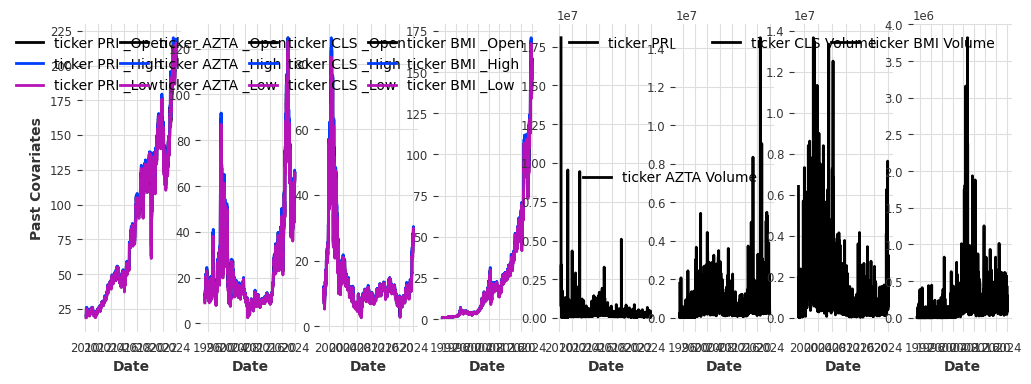

In [29]:
import matplotlib.pyplot as plt


n_plot_samples = 4
# plot sample of past covariates
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples*2, figsize=(12, 4))
for i,t in enumerate(past_covariates.keys()):
    if i < n_plot_samples:
        print(f'{t} past covariates components: {past_covariates[t].columns}')
        past_covariates[t].drop_columns(['Volume']).plot(label=f'ticker {t} ', ax=axes[i])
        past_covariates[t].univariate_component('Volume').plot(label=f'ticker {t} Volume ', ax=axes[n_plot_samples+i])

axes[0].set_ylabel('Past Covariates')


## Prepare Past Covariates

### Add sales and earnings calendar (past and forward looking) to past covariates
* Note: Research further if the data feed provides forward looking estimates at early enough dates to be seen by the model during training. It appears that some forward looking estimates are provided with a date column with value after the actual date they have become avaible.

In [30]:
import pandas as pd

earnings_loaded_df = pd.read_csv('data/earnings_calendar.csv.bz2')
print(earnings_loaded_df)

      symbol        date     eps  epsEstimated time       revenue  \
0       AAON  2024-11-04     NaN           NaN  amc           NaN   
1       AAON  2024-08-01     NaN           NaN  amc           NaN   
2       AAON  2024-05-02     NaN           NaN  amc           NaN   
3       AAON  2024-02-26     NaN          0.53  bmo           NaN   
4       AAON  2023-11-06  0.6400          0.55  amc  3.119700e+08   
...      ...         ...     ...           ...  ...           ...   
26172    ZTS  2012-03-31  0.2311           NaN  bmo  1.047000e+09   
26173    ZTS  2011-12-31  0.0180           NaN  bmo  1.127000e+09   
26174    ZTS  2011-09-30  0.1880           NaN  bmo  1.049000e+09   
26175    ZTS  2011-06-30  0.1320           NaN  bmo  1.074000e+09   
26176    ZTS  2011-03-31  0.1583           NaN  bmo  9.830000e+08   

       revenueEstimated updatedFromDate fiscalDateEnding  
0                   NaN      2024-01-13       2024-09-30  
1                   NaN      2024-01-13       2024-06

In [31]:
earnings_loaded_df.index.is_unique

True

In [32]:
earnings_loaded_df.index

RangeIndex(start=0, stop=26177, step=1)

In [33]:
len(earnings_loaded_df.index)

26177

In [34]:
earnings_loaded_df['date'] = pd.to_datetime(earnings_loaded_df['date'])

In [35]:
earnings_unique = earnings_loaded_df.drop_duplicates(subset=['symbol', 'date'])


In [36]:
assert not earnings_unique.duplicated().any()

In [37]:
earnings_unique

,symbol,date,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate,fiscalDateEnding
0,AAON,2024-11-04,NaN,NaN,amc,NaN,NaN,2024-01-13,2024-09-30
1,AAON,2024-08-01,NaN,NaN,amc,NaN,NaN,2024-01-13,2024-06-30
2,AAON,2024-05-02,NaN,NaN,amc,NaN,NaN,2024-01-13,2024-03-30
3,AAON,2024-02-26,NaN,0.53,bmo,NaN,294360000.0,2024-01-13,2023-12-30
4,AAON,2023-11-06,0.6400,0.55,amc,3.119700e+08,294360000.0,2024-01-13,2023-09-30
...,...,...,...,...,...,...,...,...,...
26172,ZTS,2012-03-31,0.2311,NaN,bmo,1.047000e+09,NaN,2023-12-04,2012-03-31
26173,ZTS,2011-12-31,0.0180,NaN,bmo,1.127000e+09,NaN,2023-12-04,2011-12-31
26174,ZTS,2011-09-30,0.1880,NaN,bmo,1.049000e+09,NaN,2023-12-04,2011-09-30
26175,ZTS,2011-06-30,0.1320,NaN,bmo,1.074000e+09,NaN,2023-12-04,2011-06-30


In [38]:
earnings_unique = earnings_unique.set_index(keys=['symbol', 'date'])

In [39]:
earnings_unique

eps  epsEstimated time       revenue  revenueEstimated  \
symbol date                                                                    
AAON   2024-11-04     NaN           NaN  amc           NaN               NaN   
       2024-08-01     NaN           NaN  amc           NaN               NaN   
       2024-05-02     NaN           NaN  amc           NaN               NaN   
       2024-02-26     NaN          0.53  bmo           NaN       294360000.0   
       2023-11-06  0.6400          0.55  amc  3.119700e+08       294360000.0   
...                   ...           ...  ...           ...               ...   
ZTS    2012-03-31  0.2311           NaN  bmo  1.047000e+09               NaN   
       2011-12-31  0.0180           NaN  bmo  1.127000e+09               NaN   
       2011-09-30  0.1880           NaN  bmo  1.049000e+09               NaN   
       2011-06-30  0.1320           NaN  bmo  1.074000e+09               NaN   
       2011-03-31  0.1583           NaN  bmo  9.830000e+08               NaN   

                  updatedFromDate fiscalDateEnding  
symbol date                                         
AAON   2024-11-04      2024-01-13       2024-09-30  
       2024-08-01      2024-01-13       2024-06-30  
       2024-05-02      2024-01-13       2024-03-30  
       2024-02-26      2024-01-13       2023-12-30  
       2023-11-06      2024-01-13       2023-09-30  
...                           ...              ...  
ZTS    2012-03-31      2023-12-04       2012-03-31  
       2011-12-31      2023-12-04       2011-12-31  
       2011-09-30      2023-12-04       2011-09-30  
       2011-06-30      2023-12-04       2011-06-30  
       2011-03-31      2023-12-04       2011-03-31  

[26167 rows x 7 columns]

In [40]:
assert earnings_unique.index.has_duplicates == False

In [41]:
# check if data for a given symbol was saved and loaded as expected
earnings_unique.xs('LRN', level='symbol')

,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate,fiscalDateEnding
date,,,,,,,
2024-10-22,NaN,NaN,amc,NaN,NaN,2024-01-13,2024-09-30
2024-08-13,NaN,NaN,amc,NaN,NaN,2024-01-13,2024-06-30
2024-04-23,NaN,NaN,amc,NaN,NaN,2024-01-13,2024-03-30
2024-01-23,NaN,1.34,amc,NaN,500850000.0,2024-01-13,2023-12-30
2023-10-24,0.11000,-0.35,amc,480181000.0,451150000.0,2024-01-13,2023-09-30
...,...,...,...,...,...,...,...
2006-06-30,0.17150,NaN,amc,29225000.0,NaN,2023-12-04,2006-06-30
2006-03-31,0.17200,NaN,amc,29226000.0,NaN,2023-12-04,2006-03-31
2005-12-31,0.17200,NaN,amc,29226000.0,NaN,2023-12-04,2005-12-31


In [42]:
print(earnings_unique.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated time      revenue  revenueEstimated updatedFromDate fiscalDateEnding
date                                                                                               
2024-10-22   NaN           NaN  amc          NaN               NaN      2024-01-13       2024-09-30
2024-08-13   NaN           NaN  amc          NaN               NaN      2024-01-13       2024-06-30
2024-04-23   NaN           NaN  amc          NaN               NaN      2024-01-13       2024-03-30
2024-01-23   NaN        1.3400  amc          NaN      5.008500e+08      2024-01-13       2023-12-30
2023-10-24  0.11       -0.3500  amc  480181000.0      4.511500e+08      2024-01-13       2023-09-30
2023-08-15  1.01        0.8700  amc  483489000.0      4.607000e+08      2023-12-04       2023-06-30
2023-04-25  1.30        1.0700  amc  470284000.0      4.607000e+08      2023-12-04       2023-03-31
2023-01-24  1.19        1.0400  amc  458435000.0               NaN      2023-12-04       2022-12-31


In [43]:
# get a clean deep copy so it is easier to debug further data cleanup steps
earnings_expanded_df = earnings_unique.copy()

In [44]:
# convert date strings to numerical representation
ufd = pd.to_datetime(earnings_expanded_df['updatedFromDate'])
ufd_year = ufd.dt.year
ufd_month = ufd.dt.month
ufd_day = ufd.dt.day

earn_n_cols = len(earnings_expanded_df.columns)
earnings_expanded_df.insert(loc=earn_n_cols, column='updatedFromDate_year', value=ufd_year)
earnings_expanded_df.insert(loc=earn_n_cols, column='updatedFromDate_month', value=ufd_month)
earnings_expanded_df.insert(loc=earn_n_cols, column='updatedFromDate_day', value=ufd_day)
earnings_expanded_df.pop('updatedFromDate')


symbol  date      
AAON    2024-11-04    2024-01-13
        2024-08-01    2024-01-13
        2024-05-02    2024-01-13
        2024-02-26    2024-01-13
        2023-11-06    2024-01-13
                         ...    
ZTS     2012-03-31    2023-12-04
        2011-12-31    2023-12-04
        2011-09-30    2023-12-04
        2011-06-30    2023-12-04
        2011-03-31    2023-12-04
Name: updatedFromDate, Length: 26167, dtype: object

In [45]:
print(earnings_expanded_df.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated time      revenue  revenueEstimated fiscalDateEnding  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year
date                                                                                                                                                 
2024-10-22   NaN           NaN  amc          NaN               NaN       2024-09-30                   13                      1                  2024
2024-08-13   NaN           NaN  amc          NaN               NaN       2024-06-30                   13                      1                  2024
2024-04-23   NaN           NaN  amc          NaN               NaN       2024-03-30                   13                      1                  2024
2024-01-23   NaN        1.3400  amc          NaN      5.008500e+08       2023-12-30                   13                      1                  2024
2023-10-24  0.11       -0.3500  amc  480181000.0      4.511500e+08       2023-09-30                 

In [46]:
# convert date strings to numerical representation
fde = pd.to_datetime(earnings_expanded_df['fiscalDateEnding'])
fde_year = fde.dt.year
fde_month = fde.dt.month
fde_day = fde.dt.day

earn_n_cols = len(earnings_expanded_df.columns)
earnings_expanded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_year', value=fde_year)
earnings_expanded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_month', value=fde_month)
earnings_expanded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_day', value=fde_day)
earnings_expanded_df.pop('fiscalDateEnding')


symbol  date      
AAON    2024-11-04    2024-09-30
        2024-08-01    2024-06-30
        2024-05-02    2024-03-30
        2024-02-26    2023-12-30
        2023-11-06    2023-09-30
                         ...    
ZTS     2012-03-31    2012-03-31
        2011-12-31    2011-12-31
        2011-09-30    2011-09-30
        2011-06-30    2011-06-30
        2011-03-31    2011-03-31
Name: fiscalDateEnding, Length: 26167, dtype: object

In [47]:
print(earnings_expanded_df.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated time      revenue  revenueEstimated  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  fiscalDateEnding_day  fiscalDateEnding_month  fiscalDateEnding_year
date                                                                                                                                                                                                     
2024-10-22   NaN           NaN  amc          NaN               NaN                   13                      1                  2024                    30                       9                   2024
2024-08-13   NaN           NaN  amc          NaN               NaN                   13                      1                  2024                    30                       6                   2024
2024-04-23   NaN           NaN  amc          NaN               NaN                   13                      1                  2024                    30                       3              

In [48]:
# convert earnings reporting time - Before Market Open / After Market Close - categories to numerical representation
earnings_expanded_df['time'] = earnings_expanded_df['time'].replace(['bmo', 'amc', '--'],
                        [0, 1, -1], inplace=False).astype('int32')



In [49]:
print(earnings_expanded_df.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated  time      revenue  revenueEstimated  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  fiscalDateEnding_day  fiscalDateEnding_month  fiscalDateEnding_year
date                                                                                                                                                                                                      
2024-10-22   NaN           NaN     1          NaN               NaN                   13                      1                  2024                    30                       9                   2024
2024-08-13   NaN           NaN     1          NaN               NaN                   13                      1                  2024                    30                       6                   2024
2024-04-23   NaN           NaN     1          NaN               NaN                   13                      1                  2024                    30                       3         

In [50]:
from darts import TimeSeries

type(earnings_expanded_df.index)

pandas.core.indexes.multi.MultiIndex

In [51]:
earnings_expanded_df.index.names

FrozenList(['symbol', 'date'])

In [52]:
earnings_expanded_df.dtypes

eps                       float64
epsEstimated              float64
time                        int32
revenue                   float64
revenueEstimated          float64
updatedFromDate_day         int32
updatedFromDate_month       int32
updatedFromDate_year        int32
fiscalDateEnding_day        int32
fiscalDateEnding_month      int32
fiscalDateEnding_year       int32
dtype: object

In [53]:
# credit for implementation: https://stackoverflow.com/a/39068260/12015435
def is_business_day(date):
    return bool(len(pd.bdate_range(date, date)))


In [54]:
t_earn = earnings_expanded_df.loc[['LRN']]
t_earn = t_earn.droplevel('symbol')
t_earn.index = pd.to_datetime(t_earn.index)
print(f'index type for {t}: {type(t_earn.index)}')
assert not t_earn.index.duplicated().any()

for i in t_earn.index:
    if not is_business_day(i):
        print(f'earnings record date is not a business day: \n{t_earn.loc[[i]]}')



index type for GWRE: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
earnings record date is not a business day: 
               eps  epsEstimated  time     revenue  revenueEstimated  \
date                                                                   
2007-09-30  0.1201           NaN     1  27196000.0               NaN   

            updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  \
date                                                                           
2007-09-30                    4                     12                  2023   

            fiscalDateEnding_day  fiscalDateEnding_month  \
date                                                       
2007-09-30                    30                       9   

            fiscalDateEnding_year  
date                               
2007-09-30                   2007  
earnings record date is not a business day: 
                eps  epsEstimated  time     revenue  revenueEstimated  \
date           

In [55]:
len(t_earn.index)

78

In [56]:
# align all dates with Business days
from pandas.tseries.offsets import BDay

def to_biz_day(date=None, report_time=None):
    if not is_business_day(date):
        if report_time == 1 or report_time =='amc':
                return date-BDay(n=1)
        else: 
            return date+BDay(n=1)
    else:
         return date

def align_to_business_days(t_earn=None):
    assert not t_earn.index.isnull().any()
    new_index = t_earn.index.map(lambda x : to_biz_day(date=x, report_time=t_earn.at[x, 'time']))
    t_earn.index = new_index
    if t_earn.index.isnull().any():
         print(t_earn[t_earn.index.isnull()])
    for i in t_earn.index:
        assert is_business_day(i)
    return t_earn


In [57]:
# backfill quarterly earnigs and revenue estimates so that the model can see the next quarter's estimates during the previou s quarter days

def back_fill_earn_estimates(t_earn=None):
    t_earn['time'].bfill(inplace=True)
    t_earn['epsEstimated'].bfill(inplace=True)
    t_earn['revenueEstimated'].bfill(inplace=True)
    t_earn['fiscalDateEnding_day'].bfill(inplace=True)
    t_earn['fiscalDateEnding_month'].bfill(inplace=True)
    t_earn['fiscalDateEnding_year'].bfill(inplace=True)
    return t_earn



In [58]:
# convert earnings dataframe to series

t_earn_series = {}
for t in ticker_series.keys():
    print(f'ticker: {t}')
    t_earn = earnings_expanded_df.loc[[t]].copy()
    t_earn = t_earn.droplevel('symbol')
    t_earn.index = pd.to_datetime(t_earn.index)
    print(f'index type for {t}: {type(t_earn.index)}')
    assert not t_earn.index.duplicated().any()
    assert not t_earn.index.isnull().any()
    t_earn = align_to_business_days(t_earn)
    print(f't_earn freq: {t_earn.index}')
    tes_tmp = TimeSeries.from_dataframe(t_earn, freq='B', fill_missing_dates=True)
    t_earn = back_fill_earn_estimates(t_earn=tes_tmp.pd_dataframe())
    tes = TimeSeries.from_dataframe(t_earn, fillna_value=-1)
    print(f'{t} earnings: \n{t_earn}')
    assert len(tes.gaps()) == 0
    t_earn_series[t] = tes


ticker: PRI
index type for PRI: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
t_earn freq: DatetimeIndex(['2024-11-05', '2024-08-05', '2024-05-06', '2024-02-22',
               '2023-11-07', '2023-08-07', '2023-05-08', '2023-02-23',
               '2022-11-08', '2022-08-08', '2022-05-05', '2022-02-14',
               '2021-11-08', '2021-08-05', '2021-05-05', '2021-02-09',
               '2020-11-04', '2020-08-05', '2020-04-29', '2020-02-11',
               '2019-11-06', '2019-08-07', '2019-05-07', '2019-02-07',
               '2018-11-06', '2018-08-07', '2018-05-08', '2018-02-07',
               '2017-11-07', '2017-08-08', '2017-05-09', '2017-02-08',
               '2016-11-09', '2016-08-08', '2016-05-04', '2016-02-10',
               '2015-11-04', '2015-08-05', '2015-05-06', '2015-02-09',
               '2014-11-04', '2014-08-06', '2014-05-05', '2014-02-10',
               '2013-11-06', '2013-08-06', '2013-05-07', '2013-02-07',
               '2012-11-07', '2012-08-07', '2012-

In [59]:
t

'GWRE'

In [60]:
print(t_earn.tail(n=330).to_string(index=True))

component    eps  epsEstimated  time      revenue  revenueEstimated  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  fiscalDateEnding_day  fiscalDateEnding_month  fiscalDateEnding_year
date                                                                                                                                                                                                      
2023-09-01   NaN          0.34   1.0          NaN       261360000.0                  NaN                    NaN                   NaN                  31.0                     7.0                 2023.0
2023-09-04   NaN          0.34   1.0          NaN       261360000.0                  NaN                    NaN                   NaN                  31.0                     7.0                 2023.0
2023-09-05   NaN          0.34   1.0          NaN       261360000.0                  NaN                    NaN                   NaN                  31.0                     7.0         

In [61]:
t_earn.index

DatetimeIndex(['2010-07-30', '2010-08-02', '2010-08-03', '2010-08-04',
               '2010-08-05', '2010-08-06', '2010-08-09', '2010-08-10',
               '2010-08-11', '2010-08-12',
               ...
               '2024-11-22', '2024-11-25', '2024-11-26', '2024-11-27',
               '2024-11-28', '2024-11-29', '2024-12-02', '2024-12-03',
               '2024-12-04', '2024-12-05'],
              dtype='datetime64[ns]', name='date', length=3745, freq='B')

In [62]:
tes.pd_dataframe()

component,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate_day,updatedFromDate_month,updatedFromDate_year,fiscalDateEnding_day,fiscalDateEnding_month,fiscalDateEnding_year
date,,,,,,,,,,,
2010-07-30,0.2539,0.01512,1.0,45782000.0,11400000.0,4.0,12.0,2023.0,31.0,7.0,2010.0
2010-08-02,-1.0000,0.01512,1.0,-1.0,11400000.0,-1.0,-1.0,-1.0,31.0,10.0,2010.0
2010-08-03,-1.0000,0.01512,1.0,-1.0,11400000.0,-1.0,-1.0,-1.0,31.0,10.0,2010.0
2010-08-04,-1.0000,0.01512,1.0,-1.0,11400000.0,-1.0,-1.0,-1.0,31.0,10.0,2010.0
2010-08-05,-1.0000,0.01512,1.0,-1.0,11400000.0,-1.0,-1.0,-1.0,31.0,10.0,2010.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-29,-1.0000,-1.00000,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,31.0,10.0,2024.0
2024-12-02,-1.0000,-1.00000,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,31.0,10.0,2024.0
2024-12-03,-1.0000,-1.00000,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,31.0,10.0,2024.0


In [63]:
t_earn_series

{'PRI': <TimeSeries (DataArray) (date: 6028, component: 11, sample: 1)>
 array([[[ 6.490e-01],
         [ 3.700e-01],
         [ 1.000e+00],
         ...,
         [ 3.000e+01],
         [ 9.000e+00],
         [ 2.001e+03]],
 
        [[-1.000e+00],
         [ 3.700e-01],
         [ 1.000e+00],
         ...,
         [ 3.100e+01],
         [ 1.200e+01],
         [ 2.001e+03]],
 
        [[-1.000e+00],
         [ 3.700e-01],
         [ 1.000e+00],
         ...,
 ...
         ...,
         [ 3.000e+01],
         [ 9.000e+00],
         [ 2.024e+03]],
 
        [[-1.000e+00],
         [-1.000e+00],
         [ 1.000e+00],
         ...,
         [ 3.000e+01],
         [ 9.000e+00],
         [ 2.024e+03]],
 
        [[-1.000e+00],
         [-1.000e+00],
         [ 1.000e+00],
         ...,
         [ 3.000e+01],
         [ 9.000e+00],
         [ 2.024e+03]]])
 Coordinates:
   * date       (date) datetime64[ns] 2001-09-28 2001-10-01 ... 2024-11-05
   * component  (component) object 'eps' ... '

In [64]:
# stack sales and earnigns to past covariates
new_past_covs = {}

for t, covs in list(past_covariates.items()):
    print(f'stacking future covs for {t}')
    past_covs_sliced = covs.slice_intersect(t_earn_series[t])
    earn_sliced = t_earn_series[t].slice_intersect(past_covs_sliced)
    new_past_covs[t] = past_covs_sliced.stack(earn_sliced)
    print(f'past covariates for {t} including earnings calendar: \n{new_past_covs[t].components}')
    print(f'past covariates for {t} start time: {new_past_covs[t].start_time()}, end time: {new_past_covs[t].end_time()}')
    print(f'past covariates for {t} sample: \n{new_past_covs[t][0].pd_dataframe()}')



stacking future covs for PRI
past covariates for PRI including earnings calendar: 
Index(['Open', 'High', 'Low', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       'updatedFromDate_month', 'updatedFromDate_year', 'fiscalDateEnding_day',
       'fiscalDateEnding_month', 'fiscalDateEnding_year'],
      dtype='object', name='component')
past covariates for PRI start time: 2010-04-01 00:00:00, end time: 2024-01-12 00:00:00
past covariates for PRI sample: 
component    Open       High        Low      Volume  eps  epsEstimated  time  \
Date                                                                           
2010-04-01  19.15  20.200001  18.610001  18080100.0 -1.0          0.37   1.0   

component   revenue  revenueEstimated  updatedFromDate_day  \
Date                                                         
2010-04-01     -1.0      1.554755e+08                 -1.0   

component   updatedFromDate_month  updatedFromDate_year  f

In [65]:
past_covariates = new_past_covs

In [66]:
t

'GWRE'

In [67]:
past_covariates[t].start_time(), past_covariates[t].end_time()

(Timestamp('2012-01-25 00:00:00'), Timestamp('2024-01-12 00:00:00'))

In [68]:
print(f'past covariates with price and earnings sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates with price and earnings sample: component        Open       High        Low     Volume     eps  epsEstimated  \
Date                                                                           
2012-01-25  16.750000  18.000000  16.450001  7030900.0 -1.0000       0.01512   
2012-01-26  17.299999  17.900000  16.770000   809500.0 -1.0000       0.01512   
2012-01-27  17.540001  17.900000  17.059999   371700.0 -1.0000       0.01512   
2012-01-30  18.100000  18.450001  17.860001   266900.0 -1.0000       0.01512   
2012-01-31  18.389999  18.500000  17.660000   206500.0  0.1441       0.01512   

component   time     revenue  revenueEstimated  updatedFromDate_day  \
Date                                                                  
2012-01-25   1.0        -1.0        11400000.0                 -1.0   
2012-01-26   1.0        -1.0        11400000.0                 -1.0   
2012-01-27   1.0        -1.0        11400000.0                 -1.0   
2012-01-30   1.0        -1.0        

In [69]:
t_earn_series[t].start_time(), t_earn_series[t].end_time()

(Timestamp('2010-07-30 00:00:00'), Timestamp('2024-12-05 00:00:00'))

### Add key metrics to past covariates

In [70]:
kms_file = 'data/keymetrics_history.csv.bz2'


In [71]:
import pandas as pd

kms_loaded_df = pd.read_csv(kms_file)
print(kms_loaded_df)

      symbol        date  calendarYear period  revenuePerShare  \
0        SSD  2023-09-30          2023     Q3        13.593701   
1        SSD  2023-06-30          2023     Q2        14.005015   
2        SSD  2023-03-31          2023     Q1        12.542361   
3        SSD  2022-12-31          2022     Q4        11.172179   
4        SSD  2022-09-30          2022     Q3        12.932100   
...      ...         ...           ...    ...              ...   
25625   ARVN  2018-03-31          2018     Q1         0.198178   
25626   ARVN  2017-12-31          2017     Q4         0.124075   
25627   ARVN  2017-09-30          2017     Q3         0.080497   
25628   ARVN  2017-06-30          2017     Q2         0.879481   
25629   ARVN  2017-03-31          2017     Q1         0.879481   

       netIncomePerShare  operatingCashFlowPerShare  freeCashFlowPerShare  \
0               2.437630                   0.000000              0.000000   
1               2.512620                   4.553235  

In [72]:
assert kms_loaded_df.index.is_unique

In [73]:
kms_loaded_df.index

RangeIndex(start=0, stop=25630, step=1)

In [74]:
len(kms_loaded_df.index)

25630

In [75]:
kms_loaded_df['date'] = pd.to_datetime(kms_loaded_df['date'])

In [76]:
kms_unique = kms_loaded_df.drop_duplicates(subset=['symbol', 'date'])


In [77]:
assert not kms_unique.duplicated().any()

In [78]:
kms_unique

,symbol,date,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
0,SSD,2023-09-30,2023,Q3,13.593701,2.437630,0.000000,0.000000,13.380967,39.122911,...,96557000.0,513307500.0,54.483075,28.852564,152.776520,1.651889,3.119307,0.589096,0.062307,0.000000
1,SSD,2023-06-30,2023,Q2,14.005015,2.512620,4.553235,4.104197,9.561555,37.013101,...,96574500.0,549301000.0,58.423190,28.396751,151.541723,1.540484,3.169377,0.593896,0.067885,-0.449038
2,SSD,2023-03-31,2023,Q1,12.542361,2.064163,0.069420,-0.370805,5.926801,34.907510,...,96571500.0,566617000.0,57.202365,30.463712,184.259396,1.573362,2.954335,0.488442,0.059132,-0.440225
3,SSD,2022-12-31,2022,Q4,11.172179,1.353119,3.204571,2.602015,14.128629,33.370008,...,98243500.0,548410500.0,50.925231,32.024534,182.247652,1.767297,2.810345,0.493834,0.040549,-0.602556
4,SSD,2022-09-30,2022,Q3,12.932100,2.061126,2.918389,2.690842,7.223554,31.241796,...,105807000.0,539932000.0,54.366039,28.718926,157.216657,1.655445,3.133822,0.572458,0.065973,-0.227548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25625,ARVN,2018-03-31,2018,Q1,0.198178,-0.200194,0.930897,0.900092,5.435910,2.480791,...,1281630.5,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.080698,-0.030805
25626,ARVN,2017-12-31,2017,Q4,0.124075,-0.228056,1.358169,1.337208,1.889431,0.011860,...,NaN,NaN,911.109535,0.000000,0.000000,0.098781,0.000000,0.000000,-19.229780,-0.020961
25627,ARVN,2017-09-30,2017,Q3,0.080497,-0.308572,-0.358904,-0.358676,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000229
25628,ARVN,2017-06-30,2017,Q2,0.879481,-3.519372,-4.494133,-4.544222,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.050089


In [79]:
kms_unique = kms_unique.set_index(keys=['symbol', 'date'])

In [80]:
kms_unique

calendarYear period  revenuePerShare  netIncomePerShare  \
symbol date                                                                  
SSD    2023-09-30          2023     Q3        13.593701           2.437630   
       2023-06-30          2023     Q2        14.005015           2.512620   
       2023-03-31          2023     Q1        12.542361           2.064163   
       2022-12-31          2022     Q4        11.172179           1.353119   
       2022-09-30          2022     Q3        12.932100           2.061126   
...                         ...    ...              ...                ...   
ARVN   2018-03-31          2018     Q1         0.198178          -0.200194   
       2017-12-31          2017     Q4         0.124075          -0.228056   
       2017-09-30          2017     Q3         0.080497          -0.308572   
       2017-06-30          2017     Q2         0.879481          -3.519372   
       2017-03-31          2017     Q1         0.879481          -3.291460   

                   operatingCashFlowPerShare  freeCashFlowPerShare  \
symbol date                                                          
SSD    2023-09-30                   0.000000              0.000000   
       2023-06-30                   4.553235              4.104197   
       2023-03-31                   0.069420             -0.370805   
       2022-12-31                   3.204571              2.602015   
       2022-09-30                   2.918389              2.690842   
...                                      ...                   ...   
ARVN   2018-03-31                   0.930897              0.900092   
       2017-12-31                   1.358169              1.337208   
       2017-09-30                  -0.358904             -0.358676   
       2017-06-30                  -4.494133             -4.544222   
       2017-03-31                  -3.728831             -3.985769   

                   cashPerShare  bookValuePerShare  tangibleBookValuePerShare  \
symbol date                                                                     
SSD    2023-09-30     13.380967          39.122911                  19.441544   
       2023-06-30      9.561555          37.013101                  16.815604   
       2023-03-31      5.926801          34.907510                  14.563201   
       2022-12-31     14.128629          33.370008                  13.013107   
       2022-09-30      7.223554          31.241796                  12.590381   
...                         ...                ...                        ...   
ARVN   2018-03-31      5.435910           2.480791                   2.480791   
       2017-12-31      1.889431           0.011860                   0.011860   
       2017-09-30           NaN                NaN                        NaN   
       2017-06-30           NaN                NaN                        NaN   
       2017-03-31     18.738486          12.694176                   0.000000   

                   shareholdersEquityPerShare  ...  averagePayables  \
symbol date                                    ...                    
SSD    2023-09-30                   39.122911  ...       96557000.0   
       2023-06-30                   37.013101  ...       96574500.0   
       2023-03-31                   34.907510  ...       96571500.0   
       2022-12-31                   33.370008  ...       98243500.0   
       2022-09-30                   31.241796  ...      105807000.0   
...                                       ...  ...              ...   
ARVN   2018-03-31                    2.480791  ...        1281630.5   
       2017-12-31                    0.011860  ...              NaN   
       2017-09-30                         NaN  ...              NaN   
       2017-06-30                         NaN  ...              NaN   
       2017-03-31                   12.694176  ...              NaN   

                   averageInventory  daysSalesOutstanding  \
symbol date                                           

In [81]:
assert kms_unique.index.has_duplicates == False

In [82]:
# check if data for a given symbol was saved and loaded as expected
kms_unique.xs('AAON', level='symbol')

,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,tangibleBookValuePerShare,shareholdersEquityPerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
date,,,,,,,,,,,,,,,,,,,,,
2023-09-30,2023,Q3,3.831670,0.590502,0.579780,0.306244,0.002604,8.382388,6.616297,8.382388,...,31063500.0,214957500.0,53.489951,13.747147,98.568015,1.682559,6.546813,0.913075,0.070446,-0.273536
2023-06-30,2023,Q2,5.230073,0.841396,1.015175,0.431417,0.096458,12.158279,9.493209,12.158279,...,30885500.0,207493500.0,55.996084,15.262268,102.068138,1.607255,5.896895,0.881764,0.069204,-0.583757
2023-03-31,2023,Q1,4.958054,0.686309,0.089913,-0.449510,0.046886,11.361059,8.646772,11.361059,...,37537000.0,199259000.0,59.586468,14.091653,95.138798,1.510410,6.386760,0.945986,0.060409,-0.539424
2022-12-31,2022,Q4,4.775174,0.729561,0.335803,0.102519,0.102238,10.516606,7.768928,10.516606,...,47063000.0,187913500.0,50.306012,23.266158,101.697234,1.789051,3.868279,0.884980,0.069372,-0.233284
2022-09-30,2022,Q3,4.561503,0.516552,0.845985,0.576005,0.201898,9.849672,7.078250,9.849672,...,42401000.0,170444500.0,54.015952,24.716520,89.935937,1.666174,3.641289,1.000712,0.052444,-0.269980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991-03-31,1991,Q1,0.090495,-0.001588,0.014289,0.014289,-0.001588,0.025402,0.025402,0.025402,...,1450000.0,4950000.0,56.842105,21.600000,88.200000,1.583333,4.166667,1.020408,-0.062500,0.000000
1990-12-31,1990,Q4,0.118167,0.000000,0.007034,0.005627,0.005627,0.023915,0.023915,0.023915,...,2250000.0,5900000.0,50.357143,20.400000,60.000000,1.787234,4.411765,1.500000,0.000000,-0.001407
1990-09-30,1990,Q3,0.177603,0.007034,-0.015826,-0.024618,0.000000,0.029894,0.029894,0.029894,...,2750000.0,6500000.0,43.663366,31.898734,77.468354,2.061224,2.821429,1.161765,0.235294,-0.008792


In [83]:
kms_loaded_df = kms_unique

In [84]:
# convert earnings reporting time - Before Market Open / After Market Close - categories to numerical representation
kms_loaded_df['period'] = kms_loaded_df['period'].replace(['Q1', 'Q2', 'Q3', 'Q4'],
                        [1, 2, 3, 4], inplace=False).astype('int32')

In [85]:
kms_loaded_df

calendarYear  period  revenuePerShare  netIncomePerShare  \
symbol date                                                                   
SSD    2023-09-30          2023       3        13.593701           2.437630   
       2023-06-30          2023       2        14.005015           2.512620   
       2023-03-31          2023       1        12.542361           2.064163   
       2022-12-31          2022       4        11.172179           1.353119   
       2022-09-30          2022       3        12.932100           2.061126   
...                         ...     ...              ...                ...   
ARVN   2018-03-31          2018       1         0.198178          -0.200194   
       2017-12-31          2017       4         0.124075          -0.228056   
       2017-09-30          2017       3         0.080497          -0.308572   
       2017-06-30          2017       2         0.879481          -3.519372   
       2017-03-31          2017       1         0.879481          -3.291460   

                   operatingCashFlowPerShare  freeCashFlowPerShare  \
symbol date                                                          
SSD    2023-09-30                   0.000000              0.000000   
       2023-06-30                   4.553235              4.104197   
       2023-03-31                   0.069420             -0.370805   
       2022-12-31                   3.204571              2.602015   
       2022-09-30                   2.918389              2.690842   
...                                      ...                   ...   
ARVN   2018-03-31                   0.930897              0.900092   
       2017-12-31                   1.358169              1.337208   
       2017-09-30                  -0.358904             -0.358676   
       2017-06-30                  -4.494133             -4.544222   
       2017-03-31                  -3.728831             -3.985769   

                   cashPerShare  bookValuePerShare  tangibleBookValuePerShare  \
symbol date                                                                     
SSD    2023-09-30     13.380967          39.122911                  19.441544   
       2023-06-30      9.561555          37.013101                  16.815604   
       2023-03-31      5.926801          34.907510                  14.563201   
       2022-12-31     14.128629          33.370008                  13.013107   
       2022-09-30      7.223554          31.241796                  12.590381   
...                         ...                ...                        ...   
ARVN   2018-03-31      5.435910           2.480791                   2.480791   
       2017-12-31      1.889431           0.011860                   0.011860   
       2017-09-30           NaN                NaN                        NaN   
       2017-06-30           NaN                NaN                        NaN   
       2017-03-31     18.738486          12.694176                   0.000000   

                   shareholdersEquityPerShare  ...  averagePayables  \
symbol date                                    ...                    
SSD    2023-09-30                   39.122911  ...       96557000.0   
       2023-06-30                   37.013101  ...       96574500.0   
       2023-03-31                   34.907510  ...       96571500.0   
       2022-12-31                   33.370008  ...       98243500.0   
       2022-09-30                   31.241796  ...      105807000.0   
...                                       ...  ...              ...   
ARVN   2018-03-31                    2.480791  ...        1281630.5   
       2017-12-31                    0.011860  ...              NaN   
       2017-09-30                         NaN  ...              NaN   
       2017-06-30                         NaN  ...              NaN   
       2017-03-31                   12.694176  ...              NaN   

                   averageInventory  daysSalesOutstanding  \
symbol date                              

In [86]:
from darts import TimeSeries

type(kms_loaded_df.index)

pandas.core.indexes.multi.MultiIndex

In [87]:
kms_loaded_df.index.names

FrozenList(['symbol', 'date'])

In [88]:
kms_loaded_df.dtypes

calendarYear                                int64
period                                      int32
revenuePerShare                           float64
netIncomePerShare                         float64
operatingCashFlowPerShare                 float64
freeCashFlowPerShare                      float64
cashPerShare                              float64
bookValuePerShare                         float64
tangibleBookValuePerShare                 float64
shareholdersEquityPerShare                float64
interestDebtPerShare                      float64
marketCap                                 float64
enterpriseValue                           float64
peRatio                                   float64
priceToSalesRatio                         float64
pocfratio                                 float64
pfcfRatio                                 float64
pbRatio                                   float64
ptbRatio                                  float64
evToSales                                 float64


In [109]:
# forward fill key metrics until the next company update so that the model can use the most recent known metrics on each timeseries step instead of sparce quarterly points in time

def forawrd_fill_key_metrics(t_kms_df=None):
    # print(f't_kms_df NaNs: \n{len(t_kms_df.isna())}')
    # print('t_kms_df before ffill', t_kms_df)
    t_kms_df.ffill(inplace=True)
    # print('t_kms_df after ffill', t_kms_df)
    # print(f't_kms_df NaNs: \n{len(t_kms_df.isna())}')
    # print(t_kms_df[t_kms_df.isna()])
    return t_kms_df



In [110]:
def kms_to_biz_days(t_kms_df=None):
    new_index = t_kms_df.index.map(lambda x : to_biz_day(date=x, report_time='bmo'))
    t_kms_df.index = new_index
    return t_kms_df



In [111]:
t_kms_series = {}
for t in list(ticker_series.keys()):
    # print(f'ticker {t}')
    t_kms_df = kms_loaded_df.loc[[t]].copy()
    t_kms_df = t_kms_df.droplevel('symbol')
    t_kms_df.index = pd.to_datetime(t_kms_df.index)
    # print(f'index type for {t}: {type(t_kms.index)}')
    assert not t_kms_df.index.duplicated().any()
    # print(f'{t} earnings: \n{t_kms.columns}')
    t_kms_df = kms_to_biz_days(t_kms_df)
    tkms_series_tmp = TimeSeries.from_dataframe(t_kms_df, freq='B', fill_missing_dates=True)
    # print(f'tkms_series_tmp start time, end time: {tkms_series_tmp.start_time()}, {tkms_series_tmp.end_time()}')
    t_kms_df=tkms_series_tmp.pd_dataframe()
    t_kms_df = forawrd_fill_key_metrics(t_kms_df)
    tkms_ser = TimeSeries.from_dataframe(t_kms_df, freq='B', fillna_value=-1)
    assert len(tkms_ser.gaps()) == 0, f'found gaps in tmks series: \n{tkms_ser.gaps()}'
    t_kms_series[t] = tkms_ser


ticker PRI
tkms_series_tmp start time, end time: 2001-10-01 00:00:00, 2023-10-02 00:00:00
ticker AZTA
tkms_series_tmp start time, end time: 1995-01-02 00:00:00, 2023-10-02 00:00:00
ticker CLS
tkms_series_tmp start time, end time: 1997-03-31 00:00:00, 2023-10-02 00:00:00
ticker BMI
tkms_series_tmp start time, end time: 1985-09-30 00:00:00, 2023-10-02 00:00:00
ticker XP
tkms_series_tmp start time, end time: 2018-12-31 00:00:00, 2023-10-02 00:00:00
ticker COF
tkms_series_tmp start time, end time: 1994-03-31 00:00:00, 2023-10-02 00:00:00
ticker OSW
tkms_series_tmp start time, end time: 2018-01-01 00:00:00, 2023-10-02 00:00:00
ticker GWRE
tkms_series_tmp start time, end time: 2001-01-31 00:00:00, 2023-10-31 00:00:00


In [112]:
t_kms_series

{'PRI': <TimeSeries (DataArray) (date: 5741, component: 59, sample: 1)>
 array([[[ 2.00100000e+03],
         [ 3.00000000e+00],
         [ 1.79841071e+01],
         ...,
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],
 
        [[ 2.00100000e+03],
         [ 3.00000000e+00],
         [ 1.79841071e+01],
         ...,
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],
 
        [[ 2.00100000e+03],
         [ 3.00000000e+00],
         [ 1.79841071e+01],
         ...,
 ...
         ...,
         [ 0.00000000e+00],
         [ 7.16976339e-02],
         [-6.55253348e-02]],
 
        [[ 2.02300000e+03],
         [ 2.00000000e+00],
         [ 1.90082839e+01],
         ...,
         [ 0.00000000e+00],
         [ 7.16976339e-02],
         [-6.55253348e-02]],
 
        [[ 2.02300000e+03],
         [ 3.00000000e+00],
         [ 1.98806488e+01],
         ...,
         [ 0.00000000e+00],
         [ 6.57571152e-02],
         [-9.49

In [113]:
tkms_ser.pd_dataframe()

component,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,tangibleBookValuePerShare,shareholdersEquityPerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
date,,,,,,,,,,,,,,,,,,,,,
2001-01-31,2001.0,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.0,-1.0,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2001-02-01,2001.0,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.0,-1.0,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2001-02-02,2001.0,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.0,-1.0,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2001-02-05,2001.0,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.0,-1.0,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2001-02-06,2001.0,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.0,-1.0,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,2023.0,4.0,3.312766,0.149957,2.125863,2.053020,9.800993,14.719142,9.973946,14.719142,...,35102500.0,12826500.0,79.607717,29.322826,9.409861,1.130544,3.069281,9.564435,0.010188,-0.072843
2023-10-26,2023.0,4.0,3.312766,0.149957,2.125863,2.053020,9.800993,14.719142,9.973946,14.719142,...,35102500.0,12826500.0,79.607717,29.322826,9.409861,1.130544,3.069281,9.564435,0.010188,-0.072843
2023-10-27,2023.0,4.0,3.312766,0.149957,2.125863,2.053020,9.800993,14.719142,9.973946,14.719142,...,35102500.0,12826500.0,79.607717,29.322826,9.409861,1.130544,3.069281,9.564435,0.010188,-0.072843


In [114]:
for c in tkms_ser.columns:
    if len(tkms_ser[c].gaps()) > 0:
        print(f'{c} NaNs: {len(tkms_ser[c].gaps())}')
        print(tkms_ser[c].gaps())




In [115]:
# stack key metrics to past covariates
new_past_covs = {}

for t, covs in list(past_covariates.items()):
    print(f'stacking kms covs for {t}')
    past_covs_sliced = covs.slice_intersect(t_kms_series[t])
    kms_sliced = t_kms_series[t].slice_intersect(past_covs_sliced)
    new_past_covs[t] = past_covs_sliced.stack(kms_sliced)
    print(f'past covariates for {t} including key metrics: \n{new_past_covs[t].components}')
    print(f'past covariates for {t} start time: {new_past_covs[t].start_time()}, end time: {new_past_covs[t].end_time()}')
    print(f'past covariates for {t} sample: \n{new_past_covs[t][0].pd_dataframe()}')



stacking kms covs for PRI
past covariates for PRI including key metrics: 
Index(['Open', 'High', 'Low', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       'updatedFromDate_month', 'updatedFromDate_year', 'fiscalDateEnding_day',
       'fiscalDateEnding_month', 'fiscalDateEnding_year', 'calendarYear',
       'period', 'revenuePerShare', 'netIncomePerShare',
       'operatingCashFlowPerShare', 'freeCashFlowPerShare', 'cashPerShare',
       'bookValuePerShare', 'tangibleBookValuePerShare',
       'shareholdersEquityPerShare', 'interestDebtPerShare', 'marketCap',
       'enterpriseValue', 'peRatio', 'priceToSalesRatio', 'pocfratio',
       'pfcfRatio', 'pbRatio', 'ptbRatio', 'evToSales',
       'enterpriseValueOverEBITDA', 'evToOperatingCashFlow',
       'evToFreeCashFlow', 'earningsYield', 'freeCashFlowYield',
       'debtToEquity', 'debtToAssets', 'netDebtToEBITDA', 'currentRatio',
       'interestCoverage', 'incomeQuality', 'divi

In [116]:
past_covariates = new_past_covs

In [117]:
t

'GWRE'

In [118]:
past_covariates[t].start_time(), past_covariates[t].end_time()

(Timestamp('2012-01-25 00:00:00'), Timestamp('2023-10-31 00:00:00'))

In [119]:
print(f'past covariates with key metrics sample: \n{past_covariates[t][0:5].pd_dataframe()}')


past covariates with key metrics sample: 
component        Open       High        Low     Volume     eps  epsEstimated  \
Date                                                                           
2012-01-25  16.750000  18.000000  16.450001  7030900.0 -1.0000       0.01512   
2012-01-26  17.299999  17.900000  16.770000   809500.0 -1.0000       0.01512   
2012-01-27  17.540001  17.900000  17.059999   371700.0 -1.0000       0.01512   
2012-01-30  18.100000  18.450001  17.860001   266900.0 -1.0000       0.01512   
2012-01-31  18.389999  18.500000  17.660000   206500.0  0.1441       0.01512   

component   time     revenue  revenueEstimated  updatedFromDate_day  ...  \
Date                                                                 ...   
2012-01-25   1.0        -1.0        11400000.0                 -1.0  ...   
2012-01-26   1.0        -1.0        11400000.0                 -1.0  ...   
2012-01-27   1.0        -1.0        11400000.0                 -1.0  ...   
2012-01-30   1.0 

In [120]:
t_kms_series[t].start_time(), t_kms_series[t].end_time()

(Timestamp('2001-01-31 00:00:00'), Timestamp('2023-10-31 00:00:00'))

### Add broad market indicators to past covariates

In [121]:
broad_market_df = pd.read_csv('data/broad_market.csv.bz2', header=[0, 1], index_col=0)

# drop Close as redundand
broad_market_df = broad_market_df.drop(columns=['Close'], level=1)

# use a subset of indicies for testing
# broad_market_df = broad_market_df[(broad_market_df.columns[:1])]

#flatten column hierarchy so Darts can use as covariate series
broad_market_df.columns = [f'{i}_{j}' for i, j in broad_market_df.columns]

# CBOE VIX volatility, DYX USD and TNT 10Y Treasury indices do not have meaningful values for Volume
broad_market_df = broad_market_df.drop(columns=['^VIX_Volume', 'DX-Y.NYB_Volume', '^TNX_Volume'])

# fix datetime index type issue
# https://stackoverflow.com/questions/48248239/pandas-how-to-convert-rangeindex-into-datetimeindex
broad_market_df.index = pd.to_datetime(broad_market_df.index)

broad_market_df

,^R2ESC_Open,^R2ESC_High,^R2ESC_Low,^R2ESC_Adj Close,^R2ESC_Volume,^SPXEW_Open,^SPXEW_High,^SPXEW_Low,^SPXEW_Adj Close,^SPXEW_Volume,...,^TNX_Adj Close,^SPX_Open,^SPX_High,^SPX_Low,^SPX_Adj Close,^SPX_Volume,DX-Y.NYB_Open,DX-Y.NYB_High,DX-Y.NYB_Low,DX-Y.NYB_Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
1927-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,17.660000,17.660000,17.660000,17.660000,0.000000e+00,NaN,NaN,NaN,NaN
1928-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,17.760000,17.760000,17.760000,17.760000,0.000000e+00,NaN,NaN,NaN,NaN
1928-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,17.719999,17.719999,17.719999,17.719999,0.000000e+00,NaN,NaN,NaN,NaN
1928-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,17.549999,17.549999,17.549999,17.549999,0.000000e+00,NaN,NaN,NaN,NaN
1928-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,17.660000,17.660000,17.660000,17.660000,0.000000e+00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08,NaN,NaN,NaN,NaN,NaN,6317.479980,6385.899902,6303.459961,6385.000000,0.0,...,4.002,4703.700195,4764.540039,4699.819824,4763.540039,3.742320e+09,102.440002,102.620003,102.080002,102.209999
2024-01-09,NaN,NaN,NaN,NaN,NaN,6384.660156,6384.660156,6334.509766,6354.080078,0.0,...,4.019,4741.930176,4765.470215,4730.350098,4756.500000,3.529960e+09,102.220001,102.660004,102.110001,102.570000
2024-01-10,NaN,NaN,NaN,NaN,NaN,6354.080078,6375.089844,6333.399902,6364.049805,0.0,...,4.030,4759.939941,4790.799805,4756.200195,4783.450195,3.498680e+09,102.480003,102.639999,102.339996,102.360001


In [122]:
broad_market_series = TimeSeries.from_dataframe(broad_market_df, freq='B')
broad_market_series = broad_market_series.slice(train_date_start, broad_market_series.end_time())
broad_market_series

<TimeSeries (DataArray) (Date: 8619, component: 42, sample: 1)>
array([[[          nan],
        [          nan],
        [          nan],
        ...,
        [  83.43000031],
        [  83.01000214],
        [  83.06999969]],

       [[          nan],
        [          nan],
        [          nan],
        ...,
        [  83.08000183],
        [  82.66000366],
        [  82.79000092]],

       [[          nan],
        [          nan],
        [          nan],
        ...,
...
        ...,
        [ 102.63999939],
        [ 102.33999634],
        [ 102.36000061]],

       [[          nan],
        [          nan],
        [          nan],
        ...,
        [ 102.76000214],
        [ 102.16000366],
        [ 102.29000092]],

       [[4247.75537109],
        [4324.00976562],
        [4239.99316406],
        ...,
        [ 102.58999634],
        [ 102.08999634],
        [ 102.40000153]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1991-01-01 1991-01-02 ... 2024-01-12
  * component  (component) object '^R2ESC_Open' ... 'DX-Y.NYB_Adj Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [123]:
broad_market_series.gaps()


,gap_start,gap_end,gap_size
0,1999-04-02,1999-04-02,1
1,1999-05-31,1999-05-31,1
2,2000-04-21,2000-04-21,1
3,2000-05-29,2000-05-29,1
4,2000-09-04,2000-09-04,1
...,...,...,...
188,2023-07-04,2023-07-04,1
189,2023-09-04,2023-09-04,1
190,2023-11-23,2023-11-23,1
191,2023-12-25,2023-12-25,1


In [124]:

filler = MissingValuesFiller(n_jobs=-1)

series_filled = filler.transform(broad_market_series)
assert len(series_filled.gaps()) == 0

In [125]:
broad_market_series = series_filled


In [126]:
print(f'past covariates without broad market indicies: {past_covariates[t].components}')


past covariates without broad market indicies: Index(['Open', 'High', 'Low', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       'updatedFromDate_month', 'updatedFromDate_year', 'fiscalDateEnding_day',
       'fiscalDateEnding_month', 'fiscalDateEnding_year', 'calendarYear',
       'period', 'revenuePerShare', 'netIncomePerShare',
       'operatingCashFlowPerShare', 'freeCashFlowPerShare', 'cashPerShare',
       'bookValuePerShare', 'tangibleBookValuePerShare',
       'shareholdersEquityPerShare', 'interestDebtPerShare', 'marketCap',
       'enterpriseValue', 'peRatio', 'priceToSalesRatio', 'pocfratio',
       'pfcfRatio', 'pbRatio', 'ptbRatio', 'evToSales',
       'enterpriseValueOverEBITDA', 'evToOperatingCashFlow',
       'evToFreeCashFlow', 'earningsYield', 'freeCashFlowYield',
       'debtToEquity', 'debtToAssets', 'netDebtToEBITDA', 'currentRatio',
       'interestCoverage', 'incomeQuality', 'dividendYield', 'payoutRatio',


In [127]:
print(f'past covariates without broad market indicies sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates without broad market indicies sample: component        Open       High        Low     Volume     eps  epsEstimated  \
Date                                                                           
2012-01-25  16.750000  18.000000  16.450001  7030900.0 -1.0000       0.01512   
2012-01-26  17.299999  17.900000  16.770000   809500.0 -1.0000       0.01512   
2012-01-27  17.540001  17.900000  17.059999   371700.0 -1.0000       0.01512   
2012-01-30  18.100000  18.450001  17.860001   266900.0 -1.0000       0.01512   
2012-01-31  18.389999  18.500000  17.660000   206500.0  0.1441       0.01512   

component   time     revenue  revenueEstimated  updatedFromDate_day  ...  \
Date                                                                 ...   
2012-01-25   1.0        -1.0        11400000.0                 -1.0  ...   
2012-01-26   1.0        -1.0        11400000.0                 -1.0  ...   
2012-01-27   1.0        -1.0        11400000.0                 -1.0  ...   
2012-

In [128]:
for t, covs in past_covariates.items():
    bm_sliced = broad_market_series.slice_intersect(covs)
    past_covariates[t] = covs.stack(bm_sliced)
    # print(f'past covariates for {t} including broad market indicies: {past_covariates[t].components}')


In [129]:
print(f'past covariates with broad market indicies components: {past_covariates[t].components}')


past covariates with broad market indicies components: Index(['Open', 'High', 'Low', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       ...
       '^TNX_Adj Close', '^SPX_Open', '^SPX_High', '^SPX_Low',
       '^SPX_Adj Close', '^SPX_Volume', 'DX-Y.NYB_Open', 'DX-Y.NYB_High',
       'DX-Y.NYB_Low', 'DX-Y.NYB_Adj Close'],
      dtype='object', name='component', length=116)


In [130]:
print(f'past covariates with broad market indicies sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates with broad market indicies sample: component        Open       High        Low     Volume     eps  epsEstimated  \
Date                                                                           
2012-01-25  16.750000  18.000000  16.450001  7030900.0 -1.0000       0.01512   
2012-01-26  17.299999  17.900000  16.770000   809500.0 -1.0000       0.01512   
2012-01-27  17.540001  17.900000  17.059999   371700.0 -1.0000       0.01512   
2012-01-30  18.100000  18.450001  17.860001   266900.0 -1.0000       0.01512   
2012-01-31  18.389999  18.500000  17.660000   206500.0  0.1441       0.01512   

component   time     revenue  revenueEstimated  updatedFromDate_day  ...  \
Date                                                                 ...   
2012-01-25   1.0        -1.0        11400000.0                 -1.0  ...   
2012-01-26   1.0        -1.0        11400000.0                 -1.0  ...   
2012-01-27   1.0        -1.0        11400000.0                 -1.0  ...   
2012-01-

### Realign target series with past covariates

In [131]:
for t, covs in past_covariates.items():
    ts_sliced = target_series[t].slice_intersect(covs)
    target_series[t] = ts_sliced

## Prepare Future Covariates

In [132]:

future_covariates = {t: ticker_series[t].univariate_component('holidays') for t in ticker_series.keys()}
future_covariates

{'PRI': <TimeSeries (DataArray) (Date: 3597, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2010-04-01 2010-04-02 ... 2024-01-12
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'AZTA': <TimeSeries (DataArray) (Date: 7552, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1995-02-02 1995-02-03 ... 2024-01-12
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'CLS': <TimeSeries (DataArray) (Date: 6664, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        

Prepare train and validation splits

In [133]:
val_start = pd.Timestamp('2023-05-05')
train_series = {}
val_series = {}
past_covariates_train = {}
past_covariates_val = {}

for t, target in target_series.items():
    train, val = target.split_before(val_start)
    # there should be no gaps in the training data
    assert(len(train.gaps().index) == 0)
    train_series[t] = train
    val_series[t] = val
    past_train, past_val = past_covariates[t].split_before(val_start)
    # there should be no gaps in the training data
    assert(len(past_train.gaps().index) == 0)
    past_covariates_train[t] = past_train 
    past_covariates_val = past_val



In [134]:
train_series, val_series

({'PRI': <TimeSeries (DataArray) (Date: 3416, component: 1, sample: 1)>
  array([[[ 16.94461441]],
  
         [[ 17.0308466 ]],
  
         [[ 17.11707878]],
  
         ...,
  
         [[179.52363586]],
  
         [[177.47381592]],
  
         [[174.71099854]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 2010-04-01 2010-04-02 ... 2023-05-04
    * component  (component) object 'Adj Close'
  Dimensions without coordinates: sample
  Attributes:
      static_covariates:  None
      hierarchy:          None,
  'AZTA': <TimeSeries (DataArray) (Date: 7371, component: 1, sample: 1)>
  array([[[ 7.85837507]],
  
         [[ 8.84067249]],
  
         [[10.01942921]],
  
         ...,
  
         [[42.61000061]],
  
         [[44.00999832]],
  
         [[44.34999847]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 1995-02-02 1995-02-03 ... 2023-05-04
    * component  (component) object 'Adj Close'
  Dimensions without coordinates: sample
  Attributes:
      static_covaria

In [135]:
past_covariates_train, past_covariates_val

({'PRI': <TimeSeries (DataArray) (Date: 3416, component: 116, sample: 1)>
  array([[[ 19.14999962],
          [ 20.20000076],
          [ 18.61000061],
          ...,
          [ 81.25      ],
          [ 80.68000031],
          [ 80.77999878]],
  
         [[ 19.68999958],
          [ 20.35000038],
          [ 19.18000031],
          ...,
          [ 81.27500153],
          [ 80.79999924],
          [ 80.93499756]],
  
         [[ 20.22999954],
          [ 20.5       ],
          [ 19.75      ],
          ...,
  ...
          ...,
          [102.40000153],
          [101.87999725],
          [101.95999908]],
  
         [[180.97000122],
          [183.47000122],
          [178.83000183],
          ...,
          [101.91999817],
          [101.06999969],
          [101.33999634]],
  
         [[177.41999817],
          [177.41999817],
          [173.        ],
          ...,
          [101.63999939],
          [101.02999878],
          [101.40000153]]])
  Coordinates:
    * Date       

Plot data splits

Text(0, 0.5, 'Target Series')

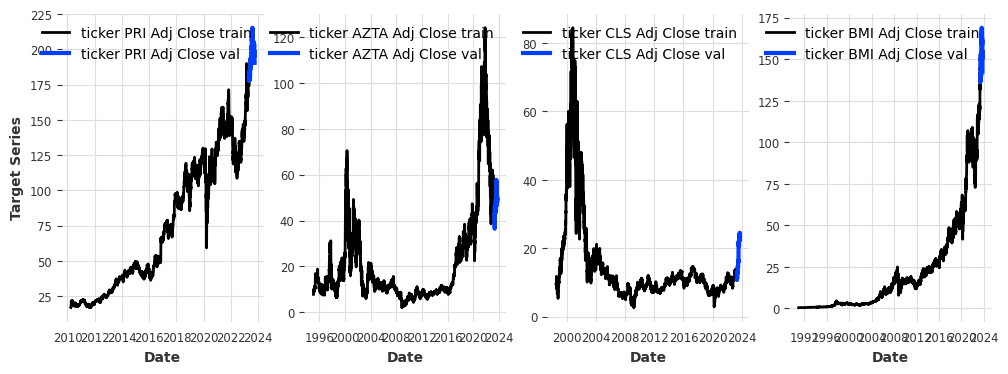

In [136]:
import matplotlib.pyplot as plt

# plot sample of target series
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples, figsize=(12, 4))
for i,t in enumerate(target_series.keys()):
    if i > n_plot_samples-1:
        break
    train_series[t].plot(label=f'ticker {t} {train_series[t].columns[0]} train', ax=axes[i])
    val_series[t].plot(label=f'ticker {t} {train_series[t].columns[0]} val', lw=3, ax=axes[i])

axes[0].set_ylabel('Target Series')


Show seasonalities

Text(0, 0.5, 'Seasonality')

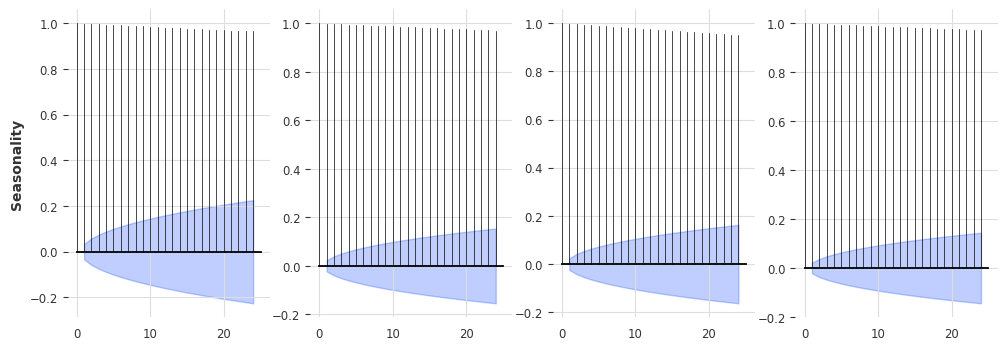

In [137]:
from darts.utils.statistics import plot_acf, check_seasonality

# plot sample of target series
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples, figsize=(12, 4))
for i,t in enumerate(target_series.keys()):
    if i >= n_plot_samples:
        break
    plot_acf(train_series[t], alpha=0.05, axis=axes[i])

axes[0].set_ylabel('Seasonality')



Train our current working model

Prepare Encoders that Darts will automatically use for training and inference

In [138]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.dataprocessing import Pipeline
# 
# scaler = Scaler(verbose=True, n_jobs=-1)

# darts encoder examples: https://unit8co.github.io/darts/generated_api/darts.dataprocessing.encoders.encoders.html#
encoders = {
    'cyclic': {'future': ['dayofweek', 'month', 'quarter']},
    "datetime_attribute": {"future": ["dayofweek", "month", "quarter", "year"]}, 
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'future': [lambda idx: (idx.year % 4)]},  # signal proximity to US election years, which is known to have significance to market cycles.
    # "transformer": scaler
}



In [140]:
train_history = 252*2 # 252 days in a year with market data
pred_horizon = 21*2 # 21 days in a month with market data
n_epochs = 50 # model training epochs

Model hyperparameter selection

In [141]:
# based on Darts template: https://unit8co.github.io/darts/examples/18-TiDE-examples.html#Model-Parameter-Setup

optimizer_kwargs = {
    "lr": 1e-3,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 200,
    "accelerator": "auto",
    "callbacks": [],
}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 10,
    "min_delta": 1e-3,
    "mode": "min",
}

#
common_model_args = {
    # "input_chunk_length": 12,  # lookback window
    # "output_chunk_length": 12,  # forecast/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    # "likelihood": None,  # use a likelihood for probabilistic forecasts
    # "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    # "force_reset": True,
    "batch_size": 256,
    "random_state": 42,
}

In [155]:
from darts.models import TiDEModel

from darts.utils.likelihood_models import QuantileRegression

saved_model_name = 'data/canswim_model.pt'
model = None

# If available, load the saved model state that performed best on validation set
try:
  print('Loading saved model')
  model = TiDEModel.load(saved_model_name)  
except Exception as e:
  print('Error loading saved model:', e)
  print('Creating a new model')
  model = TiDEModel(
      **common_model_args,
      input_chunk_length=train_history,
      output_chunk_length=pred_horizon,
      use_layer_norm=True,
      add_encoders=None, # encoders,
      dropout=0.1,
      n_epochs=n_epochs,
      use_reversible_instance_norm=True,
      likelihood=QuantileRegression(quantiles=[0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99]),
      model_name=saved_model_name,
  )
  


Loading saved model
Error loading saved model: [Errno 2] No such file or directory: 'data/canswim_model.pt'
Creating a new model


In [156]:
from darts.models import RegressionModel
from darts.models.forecasting.forecasting_model import GlobalForecastingModel

# when True, multiple time series are supported
supports_multi_ts = issubclass(model.__class__, GlobalForecastingModel)
supports_multi_ts

True

In [157]:
targets_list = [series for ticker, series in sorted(target_series.items())]
target_train_list = [series for ticker, series in sorted(train_series.items())]
print(len(target_train_list))
target_val_list = [series for ticker, series in sorted(val_series.items())]
print(len(target_train_list))
past_cov_list = [series for ticker, series in sorted(past_covariates_train.items())]
print(len(past_cov_list))
future_cov_list = [series for ticker, series in sorted(future_covariates.items())]
print(len(future_cov_list))


8
8
8
8


In [158]:
type(target_train_list[0])

darts.timeseries.TimeSeries

In [159]:
print(len(target_train_list[0].time_index))
print(len(past_cov_list[0].time_index))
print(len(future_cov_list[0].time_index))


7371
7371
7552


In [160]:
target_train_list[0].pd_dataframe()

component,Adj Close
Date,
1995-02-02,7.858375
1995-02-03,8.840672
1995-02-06,10.019429
1995-02-07,9.233593
1995-02-08,8.644212
...,...
2023-04-28,43.490002
2023-05-01,43.630001
2023-05-02,42.610001


In [161]:
target_train_list[0].start_time(), target_train_list[0].end_time()

(Timestamp('1995-02-02 00:00:00'), Timestamp('2023-05-04 00:00:00'))

In [162]:
past_cov_list[0].pd_dataframe().columns

Index(['Open', 'High', 'Low', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       ...
       '^TNX_Adj Close', '^SPX_Open', '^SPX_High', '^SPX_Low',
       '^SPX_Adj Close', '^SPX_Volume', 'DX-Y.NYB_Open', 'DX-Y.NYB_High',
       'DX-Y.NYB_Low', 'DX-Y.NYB_Adj Close'],
      dtype='object', name='component', length=116)

In [163]:
past_cov_list[0].pd_dataframe()

component,Open,High,Low,Volume,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate_day,...,^TNX_Adj Close,^SPX_Open,^SPX_High,^SPX_Low,^SPX_Adj Close,^SPX_Volume,DX-Y.NYB_Open,DX-Y.NYB_High,DX-Y.NYB_Low,DX-Y.NYB_Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
1995-02-02,9.500000,10.500000,9.000000,1789900.0,-1.0,0.15,1.0,-1.0,135340000.0,-1.0,...,7.670,470.399994,472.790009,469.950012,472.790009,3.221100e+08,87.660004,87.820000,87.589996,87.690002
1995-02-03,10.500000,12.000000,10.250000,541500.0,-1.0,0.15,1.0,-1.0,135340000.0,-1.0,...,7.457,472.779999,479.910004,472.779999,478.649994,4.410000e+08,87.720001,88.339996,87.669998,88.190002
1995-02-06,11.250000,13.000000,11.250000,369400.0,-1.0,0.15,1.0,-1.0,135340000.0,-1.0,...,7.507,478.640015,481.950012,478.359985,481.140015,3.256600e+08,88.209999,88.419998,88.080002,88.190002
1995-02-07,12.750000,12.750000,10.750000,267400.0,-1.0,0.15,1.0,-1.0,135340000.0,-1.0,...,7.511,481.140015,481.320007,479.690002,480.809998,3.146600e+08,88.110001,88.489998,88.070000,88.430000
1995-02-08,11.750000,11.750000,11.000000,120900.0,-1.0,0.15,1.0,-1.0,135340000.0,-1.0,...,7.511,480.809998,482.600006,480.399994,481.190002,3.184300e+08,88.400002,88.430000,88.099998,88.209999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-28,41.730000,43.540001,41.669998,707100.0,-1.0,-0.05,1.0,-1.0,161900000.0,-1.0,...,3.452,4129.629883,4170.060059,4127.180176,4169.479980,4.087800e+09,101.470001,102.169998,101.419998,101.669998
2023-05-01,43.480000,44.119999,43.430000,960600.0,-1.0,-0.05,1.0,-1.0,161900000.0,-1.0,...,3.574,4166.790039,4186.919922,4164.120117,4167.870117,3.321370e+09,101.669998,102.190002,101.620003,102.150002
2023-05-02,43.349998,44.000000,42.470001,909500.0,-1.0,-0.05,1.0,-1.0,161900000.0,-1.0,...,3.439,4164.100098,4164.100098,4089.719971,4119.580078,4.486130e+09,102.150002,102.400002,101.879997,101.959999


In [164]:
past_cov_list[0].start_time(), past_cov_list[0].end_time()

(Timestamp('1995-02-02 00:00:00'), Timestamp('2023-05-04 00:00:00'))

In [165]:
n_holidays = future_cov_list[0].pd_dataframe().sum()
n_holidays

component
holidays    292.0
dtype: float64

In [166]:
future_cov_list[0].start_time(), future_cov_list[0].end_time()

(Timestamp('1995-02-02 00:00:00'), Timestamp('2024-01-12 00:00:00'))

In [167]:
# train model
# for i in range(100):
model.fit(target_train_list, epochs=n_epochs, past_covariates=past_cov_list, future_covariates=future_cov_list, verbose=True, num_loader_workers=10, )
          # val_series=target_val_list[0]) # , val_future_covariates=future_cov_list[0]) 



number of `future_covariates` features is <= `temporal_width_future`, leading to feature expansion.number of covariates: 1, `temporal_width_future=4`.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 16.0 K
5 | future_cov_projection | _ResidualBlock   | 788   
6 | encoders              | Sequential       | 1.2 M 
7 | decoders              | Sequential       | 1.2 M 
8 | temporal_decoder      | _ResidualBlock   | 4.8 K 
9 | lookback_skip         | Linear           | 148 K 
-----------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.523    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# save model checkpoint
model.save(saved_model_name)


In [ ]:
# use probabilistic prediction
# see https://unit8co.github.io/darts/userguide/forecasting_overview.html#probabilistic-forecasts
pred = model.predict(pred_horizon, series=target_train_list, mc_dropout=True, num_samples=500, past_covariates=past_cov_list, future_covariates=future_cov_list)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
pred[0]

<TimeSeries (DataArray) (Date: 42, component: 1, sample: 500)>
array([[[36.5552397 , 35.56753281, 35.73997117, ..., 36.72489701,
         35.80021179, 35.74434161]],

       [[35.31641147, 35.91040543, 36.3361434 , ..., 36.5313824 ,
         36.00623068, 35.88881309]],

       [[35.45057078, 36.16889918, 34.90000737, ..., 34.90869851,
         37.19455625, 36.0421433 ]],

       ...,

       [[35.17223724, 33.89292188, 34.6794493 , ..., 35.01715585,
         33.93215455, 34.34207297]],

       [[34.33765998, 33.47680162, 35.64894054, ..., 35.58202903,
         35.7482849 , 37.90120191]],

       [[35.41980465, 36.15946989, 34.44761999, ..., 33.06142593,
         36.7686949 , 37.06465399]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2023-05-05 2023-05-06 ... 2023-06-15
  * component  (component) object 'Adj Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
pred[0].gaps()

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


,gap_start,gap_end


In [ ]:
#pred2_series = target.slice(target.start_time(), val_start+pd.Timedelta(days=60))
#pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred2

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

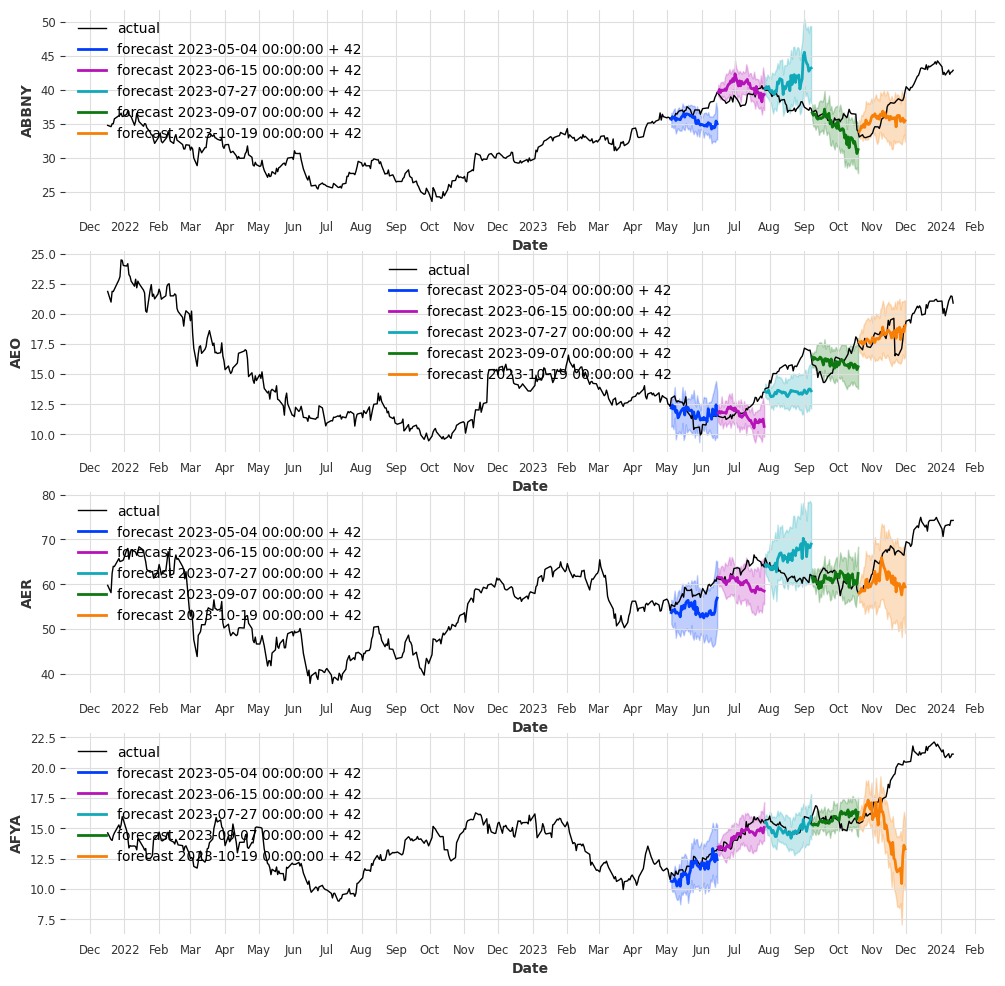

In [ ]:
import matplotlib.dates as mdates

# select a reasonable range of train and val data points for convenient visualization of results
actual = {}

fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(12, 12))


def get_pred_list(pred_start=None):
    pred_list = []
    for t, target in sorted(target_series.items()):
        pred_series = target.slice(target.start_time(), pred_start-pd.Timedelta(days=1))
        pred_list.append(pred_series)
    return pred_list


def get_past_covs(start=None):
    past_cov_list = []
    for t, past_cov in sorted(past_covariates.items()):
        past_covs_sliced = past_cov.slice(past_cov.start_time(), pred_start-pd.Timedelta(days=1))
        past_cov_list.append(past_covs_sliced)
    return past_cov_list


def plot_pred(pred_list=None, past_cov_list=None):
    #pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
    pred = model.predict(pred_horizon, series=pred_list, mc_dropout=True, num_samples=500, past_covariates=past_cov_list, future_covariates=future_cov_list)
    for i,t in enumerate(sorted(train_series.keys())):
        if i < n_plot_samples:
            # tsliced = target_series[t]
            # actual[t] = tsliced.slice(val_start-pd.Timedelta(days=train_history), target.end_time())
            # ax = actual[t].plot(label='actual', ax=axes[i])
            ax = pred[i].plot(label=f'forecast {pred_list[0].end_time()} + {pred_horizon}', linewidth=2, ax=axes[i])
            #pred2.plot(label=f'forecast {pred2_series.end_time()} + {pred_horizon}')
            plt.legend()
            # Major ticks every half year, minor ticks every month,
            ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
            ax.xaxis.set_minor_locator(mdates.MonthLocator())
            ax.grid(True)
            ax.set_ylabel(f'{t}')


def plot_actual():
    for i,t in enumerate(sorted(train_series.keys())):
        if i < n_plot_samples:
            tsliced = target_series[t]
            actual[t] = tsliced.slice(val_start-pd.Timedelta(days=train_history), target.end_time())
            ax = actual[t].plot(label='actual', linewidth=1, ax=axes[i])

plot_actual()

# show predictions at several points in time over the validation set
for w in range(5):
    pred_start = val_start + pd.Timedelta(days=w*pred_horizon)
    pred_list = get_pred_list(pred_start)
    past_cov_list = get_past_covs(pred_start)
    # print(f'pred_list: \n{pred_list}')
    plot_pred(pred_list=pred_list, past_cov_list=past_cov_list)



Backtest Model


Backtest model on the full range of test data

In [ ]:
from darts.metrics import rmse

def eval_model(model=None, series=None, start=None, past_covariates=None, future_covariates=None, forecast_horizon=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the val portion of the flow series, with a forecast_horizon:
    backtest = model.historical_forecasts(series=series, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=start, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=forecast_horizon,
                                          overlap_end=True,
                                          num_samples=500, # probabilistic forecasting
                                          predict_kwargs={'mc_dropout': True, 'num_loader_workers': 10, 'n_jobs': -1}
                                          )
    
    return backtest


In [ ]:
# set the forecast start at a time before the validation date in order to see 
# the difference between predicting on training vs validation data
# predicting up to the validate date should be near match to actuals
# whereas predicting on unseen validate data should have room for improvement
forecast_start = val_start-pd.Timedelta(days=120)
forecast_horizon = pred_horizon # pred_horizon

backtest = eval_model(model=model, series=targets_list, start=forecast_start, forecast_horizon=forecast_horizon, past_covariates=past_cov_list, future_covariates=future_cov_list)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


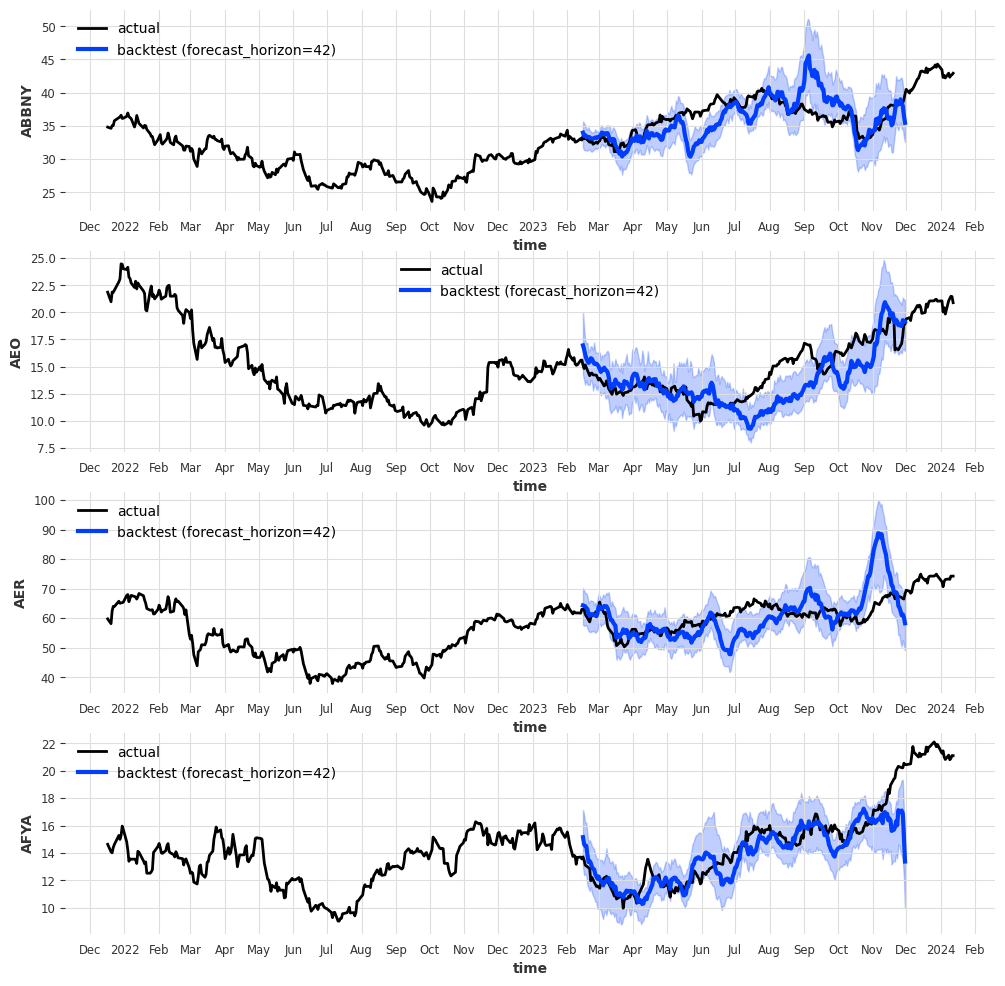

In [ ]:

fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(12, 12))

for i,t in enumerate(sorted(train_series.keys())):
    if i < n_plot_samples:
        tsliced = target_series[t]
        actual[t] = tsliced.slice(val_start-pd.Timedelta(days=train_history), target.end_time())
        ax = actual[t].plot(label='actual', ax=axes[i])
        backtest[i].plot(label=f'backtest (forecast_horizon={forecast_horizon})', linewidth=3, ax=axes[i])
        plt.legend()

        # Major ticks every half year, minor ticks every month,
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(True)
        ax.set_ylabel(f'{t}')



In [ ]:
print('Backtest RMSE = {}'.format(rmse(target_train_list, backtest)))


Backtest RMSE = [1.2697810629447275, 0.8398821457532359, 2.4882244979549997, 0.8460655823479194, 3.6454342795045624, 5.315624458096714, 2.028544778582977, 7.1815135754502055, 7.937770702058014, 8.123061855256607, 4.157151449119201, 1.9401146609296014, 3.584296304194841, 17.695376643237744, 9.355478531908172, 9.15189971713478, 4.432368250309797, 6.974082775344514, 3.231902381790267, 3.9738751323657753, 2.4530384369135465, 1.014660345175774, 3.6481300637309366, 2.3488355665898744, 3.5577243961399345, 2.0210568216638247, 3.8480802923269652, 2.604973620580443, 4.989657267170485, 20.752824233241657, 0.5843773550345721, 3.0868095733684706, 1.2746857876753872, 2.549299072074785, 2.6163973276793104, 11.990512454352736, 0.9229528667602608, 4.529868269627906, 10.19459756134936, 2.3007975820873727, 1.4554051257120602, 2.3942201770277793, 2.3896646989022297, 6.120234824560842, 1.2242120232820672, 1.4033550472340528, 4.972127398678811, 0.9905209981250489, 0.40970260329282865, 2.750385611640034, 11.